## Maxwell Fine Jul 9 2024

### This notebook is for 1) trying out DBscan, and 2) using DBscan to cluster candidate signals from `presto`

Clustering is done between `DM` and `time`. RFI, and Real signals are picked up as mulitple candidates in both time, and DM, with little seperation. Signals that are bright will trigger in multiple DMs but still be relatively isolated in time. 


### dbscan has two arguments:
- eps (ε): The maximum distance between two samples for one to be considered as in the neighborhood of the other. This is not a maximum bound on the distances of points within a cluster. This is the most important DBSCAN parameter to choose appropriately for your data set and distance function.
- min_samples: The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself. If `min_samples` is set to a higher value, DBSCAN will find denser clusters, whereas if it is set to a lower value, the found clusters will be more sparse.

### Note:
- There is only one eps parameters, as opposed to n for n dimensions. In higher dimensions, we typically want to cluster paremters with - different units. To do this we must `rescale` the dimensions so that they are comparable.
- each candidate file has a time width of 40ms, so clusters should not have a temporal width of 40ms>  


### Idea:
- We know that temporally (time), bursts have a width of ~1ms or 1/1000 of a second, we can try to force rescale DM so that the spacing between each DM sample is ~1/1000 of a DM unit pc/cm^3. This should let us cluster the same signals together as the burst duration and sepeartion in DM would then be comparable.
- min_samples = 3, we expect a signal to be at the real DM, and one +/- the real DM


### Suggestion For Future Improvement:
- take into account simga for clustering in 3D



### Outline of notebook:
- imports 
- function to read in the data 
- function to rescale DM, and add it back into the df
- function to perform dbscan clustering 
- read in, grid search to find reasonable parameters for ddm, and eps
- plotting cells
- function to make new df with only the brightest of each cluster (optional, throw out signals from -1)
- test modifcation of code for `check_frb.py`

### My selected values are:

### ddm = 0.0001
### eps = 0.01


In [43]:
# imports
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score # metric for how well dbscan worked
import pandas as pd
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
from your.candidate import Candidate
#from candidate_maker import make_candidate # uncomment out on `check_frb.py`

threshold = 6

# test .singlepulse file
data_file = 'FRB20240619D_PV_Band_2024_07_07_02_04_31_DM474.00.singlepulse'
data_dir = '/data/frb/2024-07-07/process/'

single_pulse_files_txt = 'singlepulse_test.txt'

In [44]:
# make list of file names
single_pulse_files_list = []

with open(single_pulse_files_txt, 'r') as file:
            for line in file:
                single_pulse_files_list.append(data_dir + '/' + line.strip())
                
print(single_pulse_files_list)





['/data/frb/2024-07-07/process//FRB20240619D_PV_Band_2024_07_07_02_04_31_DM470.00.singlepulse', '/data/frb/2024-07-07/process//FRB20240619D_PV_Band_2024_07_07_02_04_31_DM471.00.singlepulse', '/data/frb/2024-07-07/process//FRB20240619D_PV_Band_2024_07_07_02_04_31_DM472.00.singlepulse', '/data/frb/2024-07-07/process//FRB20240619D_PV_Band_2024_07_07_02_04_31_DM473.00.singlepulse', '/data/frb/2024-07-07/process//FRB20240619D_PV_Band_2024_07_07_02_04_31_DM474.00.singlepulse', '/data/frb/2024-07-07/process//FRB20240619D_PV_Band_2024_07_07_02_04_31_DM475.00.singlepulse', '/data/frb/2024-07-07/process//FRB20240619D_PV_Band_2024_07_07_02_04_31_DM476.00.singlepulse', '/data/frb/2024-07-07/process//FRB20240619D_PV_Band_2024_07_07_02_04_31_DM477.00.singlepulse', '/data/frb/2024-07-07/process//FRB20240619D_PV_Band_2024_07_07_02_04_31_DM478.00.singlepulse', '/data/frb/2024-07-07/process//FRB20240619D_PV_Band_2024_07_07_02_04_31_DM479.00.singlepulse', '/data/frb/2024-07-07/process//FRB20240619D_PV_Ba

In [46]:
# when we put this into the pipeline script, we will need to edit this function sliglhty 
def load_and_concat_single_pulse_files(single_pulse_files_list):
    '''
    Load multiple single pulse files into a single pandas DataFrame.

    Parameters:
    - single_pulse_files_list (list): List of Paths to single pulse files.

    Returns:
    - pd.DataFrame: A concatenated DataFrame containing data from all single pulse files.
    '''
    # Create a list of DataFrames using a list comprehension
    dfs = [pd.read_csv(pulse_file, comment='#', sep='\s+', 
                       names=['DM', 'Sigma', 'Time (s)', 'Sample', 'Downfact']) 
           for pulse_file in single_pulse_files_list]

    # Concatenate all DataFrames
    master_df = pd.concat(dfs, ignore_index=True)
    
    return master_df

In [3]:
def rescale_dm(master_df, ddm=1/1500):
    '''
    Rescale the 'DM' column in a pandas DataFrame according to a specified differential DM (ddm) value.

    Parameters:
    master_df (pd.DataFrame): A pandas DataFrame containing 'DM' and 'Time (s)' columns of all the candiates.
    ddm (float): The desired separation in dm units (pc/cm^3) after rescaling. Default is 1/1500.

    Returns:
    pd.DataFrame: The DataFrame with an additional column 'rescaled_DM' containing the rescaled DM values.
    '''
    
    if master_df.empty:
        raise ValueError("The input DataFrame is empty")
        
    if 'DM' not in master_df.columns or 'Time (s)' not in master_df.columns:
        raise ValueError("The input DataFrame must contain 'DM' and 'Time (s)' columns")

    raw_data = np.asarray(master_df[['DM', 'Time (s)']])

    # Estimate separation in dm
    raw_ddm = (np.max(raw_data[:, 0]) - np.min(raw_data[:, 0])) / (np.size(raw_data[:, 0]) - 1)

    if raw_ddm == 0:
        raise ValueError("The 'DM' values are constant, cannot rescale")

    # Calculate the scaling factor
    scaling_factor = ddm / raw_ddm

    # Find Time range, and center
    time_center = 0.5* (np.max(raw_data[:,1]) + np.min(raw_data[:,1]) )
    time_range = np.max(raw_data[:,1]) - np.min(raw_data[:,1])

    # Find Dm range, and center
    dm_center = 0.5* (np.max(raw_data[:,0]) + np.min(raw_data[:,0]) )
    dm_range = np.max(raw_data[:,0]) - np.min(raw_data[:,0])


    # Center DM on 0
    # rescale the range of DM to be the range of time * scaling_factor
    # Add rescaled_dm back into pandas df
    raw_data[:,0] = ((raw_data[:,0] - dm_center ))/ dm_range

    
    master_df['rescaled_DM'] = scaling_factor * raw_data[:, 0]

    return master_df


In [4]:
def dbscan_clustering(master_df, ddm=1/1500, eps=1/1000, min_samples=3, silhouette=False):
    """
    Perform DBSCAN clustering on a given DataFrame and optionally compute the silhouette score, performs the rescaling of dm. 

    Parameters:
    master_df (pd.DataFrame): A pandas DataFrame containing the data to be clustered. Must include 'rescaled_DM' and 'Time (s)' columns.
    ddm (float): The desired separation in dm units (pc/cm^3) after rescaling. Default is 1/1500.
    eps (float): The maximum distance between two samples for one to be considered as in the neighborhood of the other. Default is 1/1000.
    minsamples (int): The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. Default is 3.
    silhouette (bool): If True, compute and return the silhouette score. Default is False. See 
    https://en.wikipedia.org/wiki/Silhouette_(clustering), a score of ~0.7> means good. 

    Returns:
    pd.DataFrame: The original DataFrame with an added column 'cluster_labels' indicating the cluster assignment for each sample.
    float (optional): The silhouette score of the clustering if `silhouette_score` is True. labels of -1 indicate outlyers. 

    """

    master_df = rescale_dm(master_df, ddm=ddm) # rescale dm
    
    data = np.asarray(master_df[['rescaled_DM', 'Time (s)']])
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clustering = dbscan.fit(data)
    cluster_labels = clustering.labels_

    # Add labels back into pandas df
    # -1 is noise
    master_df['cluster_labels'] = cluster_labels

    # Compute the silhouette score
    if silhouette:
        if len(set(cluster_labels)) > 1:
            silhouette_avg = silhouette_score(data, cluster_labels)
        else:
            silhouette_avg = -1  # Silhouette score is not defined for a single cluster
        return master_df, silhouette_avg
    else:
        return master_df


### Grid Search 

In [48]:
master_df = load_and_concat_single_pulse_files(single_pulse_files_list)


# Generate logspaced values
eps_values = np.logspace(-4, 1, 6)
ddm_values = np.logspace(np.log10(0.00001), np.log10(0.01), 5)

# Perform grid search
best_score = -1
best_params = None
results = []

time_arr= np.asarray(master_df['Time (s)'])



print('ddm, eps, score, ')
for ddm in ddm_values:
    for eps in eps_values:
        _, score = dbscan_clustering(master_df, ddm=ddm, eps=eps, min_samples=3, silhouette=True)
        results.append((ddm, eps, score))
        labels = np.asarray(master_df['cluster_labels'])
  

        print(ddm, eps, score, )
        if score > best_score:
            best_score = score
            best_params = (ddm, eps)


print('best_params (ddm, eps), best_score')
print(best_params, best_score) 



ddm, eps, score, 
1e-05 0.0001 -1
1e-05 0.001 0.09172236822911513
1e-05 0.01 0.8623157646429047
1e-05 0.1 0.8496115414649946
1e-05 1.0 0.7316141911366459
1e-05 10.0 0.6687729607780075
5.623413251903491e-05 0.0001 -1
5.623413251903491e-05 0.001 0.16911746895248625
5.623413251903491e-05 0.01 0.8247614643909569
5.623413251903491e-05 0.1 0.8431857601863347
5.623413251903491e-05 1.0 0.7315689745804953
5.623413251903491e-05 10.0 0.6687707796029997
0.00031622776601683794 0.0001 -1
0.00031622776601683794 0.001 0.17145917578490588
0.00031622776601683794 0.01 0.6380472571611917
0.00031622776601683794 0.1 0.7773205951908359
0.00031622776601683794 1.0 0.7309467244088244
0.00031622776601683794 10.0 0.6687412879017719
0.0017782794100389228 0.0001 -1
0.0017782794100389228 0.001 0.17166686726574718
0.0017782794100389228 0.01 0.2544927455747127
0.0017782794100389228 0.1 0.4166442867217818
0.0017782794100389228 1.0 0.723069514045106
0.0017782794100389228 10.0 0.6683424894161594
0.01 0.0001 -1
0.01 0.001

score  0.7935392812337168
clusters with width longer hten 40ms  (40,)


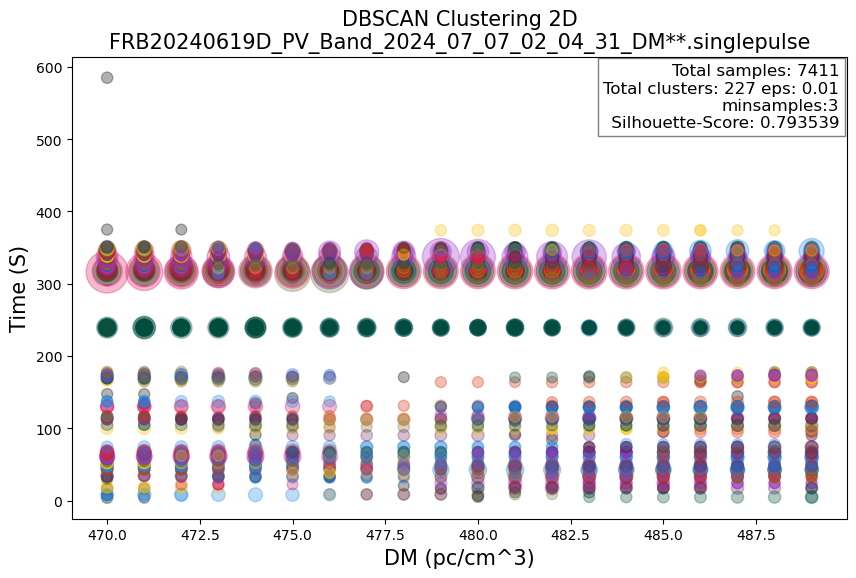

In [49]:
ddm = 0.0001
eps = 0.01


master_df, score = dbscan_clustering(master_df, ddm=ddm, eps=eps, min_samples=3, silhouette=True)
print('score ',score)


# Create a list of colors to cycle through
color_list = [ '#D81B60', '#1E88E5', '#FFC107', '#004D40', '#74285B', '#9C30C8', '#136FC9', '#D52803', '#7E723A']
num_colors = len(color_list)

# Assume data_scaled and labels are already defined
data = np.asarray(master_df[['rescaled_DM', 'Time (s)']])
data = np.asarray(master_df[['DM', 'Time (s)']])
data = np.asarray(data)
labels = np.asarray(master_df['cluster_labels'])
unique_labels = np.unique(labels)

sigma = np.asarray(master_df['Sigma'])


# Annotate with total number of samples and clusters
total_samples = data.shape[0]
total_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)  # Excluding noise if present
min_samples = 3 


time_arr= np.asarray(master_df['Time (s)'])#, 'cluster_labels']
labels = labels

widths = []

for idx, label in enumerate(unique_labels):
    if label == -1:
        color = 'k'  # Black color for noise
        pass
    else:
        width = np.ptp(time_arr[labels == label])
        widths.append(width*1000)
widths = np.asarray(widths)
print('clusters with width longer hten 40ms ',np.shape(widths[widths>40]))

plt.figure(figsize=(10, 6))
plt.text(0.99, 0.84, f'Total samples: {total_samples}\nTotal clusters: {total_clusters} eps: {eps}\nminsamples:{min_samples}\n Silhouette-Score: {score:4f}',
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right',
         bbox=dict(facecolor='white', alpha=0.5))


# Plot points for each cluster with different colors
for idx, label in enumerate(unique_labels):
    if label == -1:
        color = 'k'  # Black color for noise
    else:
        color = color_list[idx % num_colors]  # Cycle through the color list
    
    plt.scatter(data[:, 0][labels == label], data[:, 1][labels == label], color=color, s=10*sigma[labels == label], edgecolor=None, alpha=0.3,)#label=f'Cluster {label}')


plt.title('DBSCAN Clustering 2D\nFRB20240619D_PV_Band_2024_07_07_02_04_31_DM**.singlepulse', fontsize=15)
plt.xlabel('DM (pc/cm^3)', fontsize=15)
plt.ylabel('Time (S)', fontsize=15)
#plt.legend(loc='best')
plt.savefig('DBscan_clustering_final_v1.png', bbox_inches='tight')
#plt.ylim(320, 325)
plt.show()

#################################################################
#################################################################
######################################################################



score  0.7935392812337168
clusters with width longer hten 40ms  (40,)


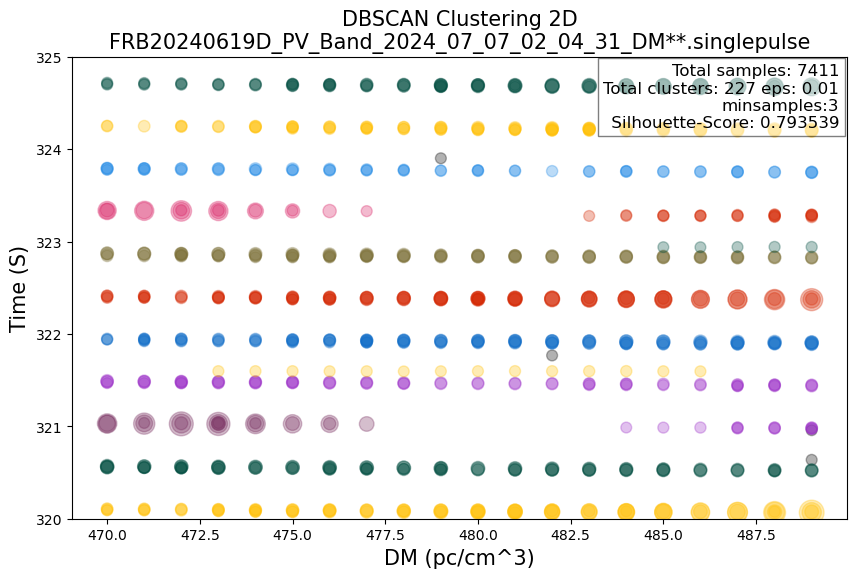

In [50]:
ddm = 0.0001
eps = 0.01


master_df, score = dbscan_clustering(master_df, ddm=ddm, eps=eps, min_samples=3, silhouette=True)
print('score ',score)


# Create a list of colors to cycle through
color_list = [ '#D81B60', '#1E88E5', '#FFC107', '#004D40', '#74285B', '#9C30C8', '#136FC9', '#D52803', '#7E723A']
num_colors = len(color_list)

# Assume data_scaled and labels are already defined
data = np.asarray(master_df[['rescaled_DM', 'Time (s)']])
data = np.asarray(master_df[['DM', 'Time (s)']])
data = np.asarray(data)
labels = np.asarray(master_df['cluster_labels'])
unique_labels = np.unique(labels)

sigma = np.asarray(master_df['Sigma'])


# Annotate with total number of samples and clusters
total_samples = data.shape[0]
total_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)  # Excluding noise if present
min_samples = 3 


time_arr= np.asarray(master_df['Time (s)'])#, 'cluster_labels']
labels = labels

widths = []

for idx, label in enumerate(unique_labels):
    if label == -1:
        color = 'k'  # Black color for noise
        pass
    else:
        width = np.ptp(time_arr[labels == label])
        widths.append(width*1000)
widths = np.asarray(widths)
print('clusters with width longer hten 40ms ',np.shape(widths[widths>40]))

plt.figure(figsize=(10, 6))
plt.text(0.99, 0.84, f'Total samples: {total_samples}\nTotal clusters: {total_clusters} eps: {eps}\nminsamples:{min_samples}\n Silhouette-Score: {score:4f}',
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right',
         bbox=dict(facecolor='white', alpha=0.5))


# Plot points for each cluster with different colors
for idx, label in enumerate(unique_labels):
    if label == -1:
        color = 'k'  # Black color for noise
    else:
        color = color_list[idx % num_colors]  # Cycle through the color list
    
    plt.scatter(data[:, 0][labels == label], data[:, 1][labels == label], color=color, s=10*sigma[labels == label], edgecolor=None, alpha=0.3,)#label=f'Cluster {label}')


plt.title('DBSCAN Clustering 2D\nFRB20240619D_PV_Band_2024_07_07_02_04_31_DM**.singlepulse', fontsize=15)
plt.xlabel('DM (pc/cm^3)', fontsize=15)
plt.ylabel('Time (S)', fontsize=15)
#plt.legend(loc='best')
plt.ylim(320, 325)
plt.savefig('DBscan_clustering_final_v1_zoom.png', bbox_inches='tight')
plt.show()

#################################################################
#################################################################
######################################################################



In [51]:
def get_candidates(master_df, ddm=1/1500, eps=1/1000, min_samples=3, silhouette=False, include_outliers=True):
    master_df = dbscan_clustering(master_df, ddm=ddm, eps=eps, min_samples=min_samples, silhouette=silhouette)

    # Group by 'cluster_labels' and find the row with the max 'Sigma' for each group
    cluster_labels = master_df['cluster_labels'].to_numpy()
    sigmas = master_df['Sigma'].to_numpy()
    unique_labels = np.unique(cluster_labels)
    print(len(unique_labels))

    indices = []
    for label in unique_labels:
        if label == -1 and not include_outliers:
            continue
        mask = cluster_labels == label
        max_sigma_index = np.argmax(sigmas[mask])
        indices.append(np.where(mask)[0][max_sigma_index])

    result = master_df.iloc[indices].reset_index(drop=True)

    return result

In [56]:
result_df = get_candidates(master_df, ddm=0.0001, eps=0.01, min_samples=3, silhouette=False, include_outliers=True)

228


In [57]:
result_df

,DM,Sigma,Time (s),Sample,Downfact,rescaled_DM,cluster_labels
0,472.0,7.59,346.147968,1802854,1,-0.015395,-1
1,474.0,10.01,8.259840,43020,30,-0.011289,0
2,470.0,7.46,18.418752,95931,30,-0.019500,1
3,470.0,6.30,32.706816,170348,30,-0.019500,2
4,470.0,8.19,34.541184,179902,30,-0.019500,3
...,...,...,...,...,...,...,...
223,488.0,6.39,340.336320,1772585,30,0.017447,222
224,487.0,6.32,31.752960,165380,30,0.015395,223
225,488.0,6.49,308.083200,1604600,30,0.017447,224
226,488.0,6.28,328.332288,1710064,30,0.017447,225


In [54]:
from your.candidate import Candidate

#from candidate_maker import make_candidate

In [55]:
def make_candidate(filterbankname, dm, tcand, sigma):
    cand = Candidate(
        fp=filterbankname,
        dm=dm,
        tcand=tcand,
        width=2,
        label=-1,
        snr=sigma,
        min_samp=256,
        device=0,
    )
    cand.get_chunk()
    cand.dmtime()
    cand.dedisperse()
    cand.dm_opt, cand.snr_opt = cand.optimize_dm()
    cand.resize(key="ft", size=256, axis=0, anti_aliasing=True)  # Resize along time axis
    cand.resize(key="ft", size=256, axis=1, anti_aliasing=True)  # Resize along frequency axis
    cand.resize(key="dmt", size=256, axis=1, anti_aliasing=True)

    return cand


### 'Modified 'check_frb.py' script 






oringal is:

starting at 178:
```
    if not dry_run:
        with subprocess.Popen(singlepulse_command, stdout=subprocess.PIPE, bufsize=1, text=True, shell=True) as p:
            for line in p.stdout:
                if not quiet:
                    print(line, end='')
                if "pulse candidates" in line:
                    num_pulse_candidates += int(line.split()[1])


central_singlepulse_file = f"{basename}_DM{dm:.2f}.singlepulse"
    if not dry_run:
        try:
            with open(central_singlepulse_file, "rb") as f:
                num_pulse_candidates_exact_dm = max(sum(1 for _ in f) - 1, 0)
        except FileNotFoundError:
            num_pulse_candidates_exact_dm = "error"

```



starting at 210:

```    if not dry_run:
        if num_pulse_candidates < 200:
            if not quiet:
                print(f"Going to create <200 candidates total for all DMs")
            for singlepulse_file in sorted(glob(f"{basename}_DM*.singlepulse")):
                make_candidates_for_singlepulsefile(filterbankfile, singlepulse_file, sigma=threshold)
        elif num_pulse_candidates_exact_dm != "error" and num_pulse_candidates_exact_dm < 1000:
            if not quiet:
                print(f"Going to create {num_pulse_candidates_exact_dm} candidates for central DM")
            make_candidates_for_singlepulsefile(filterbankfile, central_singlepulse_file, sigma=threshold)
        else:
            print(f"Not making {num_pulse_candidates_exact_dm} candidates for {basename}.fil")
    else:
        print("Create candidates for {central_singlepulse_file}")
```

In [ ]:
 
#from candidate_maker import make_candidate # uncomment out on `check_frb.py`


# TODO Max Fine 2024-07-09
# add clustering args to cli
include_outliers = True # make command line arg

if not dry_run:
    # read in candiate files, and count clusters
    single_pulse_files_list = sorted(glob(f"{basename}_DM*.singlepulse"))
    master_pulse_df = load_and_concat_single_pulse_files(single_pulse_files_list)

    # cluster, and only keep the highest sigma candiate from each cluster
    result_df = get_candidates(master_pulse_df, ddm=0.0001, eps=0.01, min_samples=3, silhouette=False, 
                               include_outliers=include_outliers)

    
    # TODO Max Fine 2024-07-09
    # can we use vector logic for the make_candidate function? would save us a for loop
    dm = result_df['DM'].to_numpy()
    time = result_df['Time (s)'].to_numpy()

    for index, (dm_value, time_value) in enumerate(zip(dm, time)):
        cand = make_candidate(filterbankfile, dm, time, sigma=threshold)
        fout = cand.save_h5(fnout=make_output_name(filterbankfile, cand))





